# 12wk-1: 순환신경망 (2) – 순환신경망의 이해, `rNNCell`, `RNNCell`

최규빈  
2024-05-20

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/12wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xq0bBQn8ZP607mS0ZKI8Sg&si=-cQULuc2x7noftgE>

# 2. Import

In [177]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [178]:
soft = torch.nn.Softmax(dim=1)

# 3. AbAcAd – 실패

## A. Data

`-` 데이터 정리

In [179]:
txt = list('AbAcAd'*50)
txt[:10]

In [180]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

In [181]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))

In [182]:
x[:8],y[:8]

## B. 풀이 – 실패

In [183]:
net = torch.nn.Sequential(
    torch.nn.Embedding(4,2),
    torch.nn.Tanh(),
    torch.nn.Linear(2,4)
)
ebdd,tanh,linr = net
ebdd.weight.data = ebdd.weight.data*0 +0.1
linr.weight.data = linr.weight.data*0 +0.1
linr.bias.data = linr.bias.data*0 +0.1
#
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
#---#
for epoc in range(200):
    # 1 
    netout = net(x)
    # 2 
    loss = loss_fn(netout,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

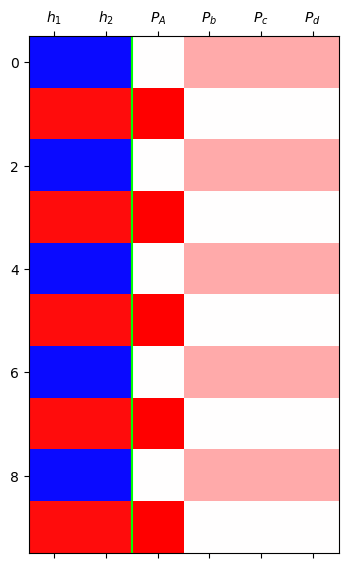

In [169]:
h = tanh(ebdd(x))
yhat = soft(net(x))
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap="bwr",vmin=-1,vmax=1)
plt.axvline(1.5,color="lime")
plt.xticks(ticks=range(6),labels=[r"$h_1$",r"$h_2$",r"$P_A$",r"$P_b$",r"$P_c$",r"$P_d$"]);

-   망했음
-   왜?

`-` 일단 망한건 망한거고 분석을 위해서 숫자좀 체크하자.

In [168]:
net(x)

## C. 실패한 풀이의 다른구현1

`-` B를 다른방식으로 구현해보자.

`-` 새로운 방식의 데이터 정리

In [40]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

`-` 사용자 정의 Hnet를 사용

In [41]:
class Hnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2,bias=False)
        self.tanh = torch.nn.Tanh()
    def forward(self,X):
        h = self.tanh(self.i2h(X))
        return h
hnet = Hnet()
linr = torch.nn.Linear(2,4)
hnet.i2h.weight.data = hnet.i2h.weight.data*0 + 0.1
linr.weight.data = linr.weight.data*0 + 0.1
linr.bias.data = linr.bias.data*0 + 0.1
# 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()),lr=0.1)
#---#
for epoc in range(200):
    # 1 
    h = hnet(X)
    netout = linr(h)
    # 2 
    loss = loss_fn(netout,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 이것도 숫자좀 체크해보자.

In [42]:
linr(hnet(X))

-   이전코드와 결과가 같음

## D. 실패한 풀이의 다른구현2

`# 예비학습` – 아래를 관찰하자.

In [43]:
X = torch.tensor(
    [[1., 0., 0., 0.],
     [0., 1., 0., 0.]]
)
linr = torch.nn.Linear(4,2)

In [44]:
linr(X)

In [45]:
linr(X[[0]]),linr(X[[1]])

In [46]:
linr(X[0]),linr(X[1])

`#`

`-` 또 다른방식의 구현

In [47]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [48]:
class Hnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2,bias=False)
        self.tanh = torch.nn.Tanh()
    def forward(self,X):
        h = self.tanh(self.i2h(X))
        return h
hnet = Hnet()
linr = torch.nn.Linear(2,4)
hnet.i2h.weight.data = hnet.i2h.weight.data*0 + 0.1
linr.weight.data = linr.weight.data*0 + 0.1
linr.bias.data = linr.bias.data*0 + 0.1
# 
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(hnet.parameters())+list(linr.parameters()),lr=0.1)
#---#
L = len(X)
for epoc in range(200):
    # 1~2 
    loss = 0 
    for t in range(L):
        Xt,yt = X[t],y[t]
        ht = hnet(Xt)
        ot = linr(ht)
        loss = loss + loss_fn(ot,yt)
    loss = loss/L
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 이것도 숫자좀 체크해보자.

In [49]:
linr(hnet(X))

`-` 임베딩공간의 해석

In [50]:
h = hnet(X)

In [51]:
h.shape

In [52]:
h1,h2 = h.T.data
# h1 = h[:,0].data
# h2 = h[:,1].data

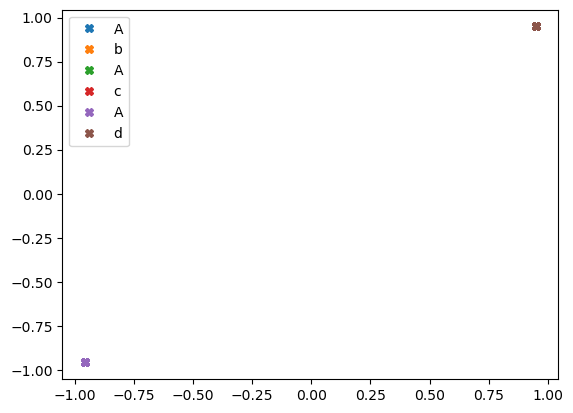

In [53]:
plt.plot(h1[::6],h2[::6],'X',label="A")
plt.plot(h1[1::6],h2[1::6],'X',label="b")
plt.plot(h1[2::6],h2[2::6],'X',label="A")
plt.plot(h1[3::6],h2[3::6],'X',label="c")
plt.plot(h1[4::6],h2[4::6],'X',label="A")
plt.plot(h1[5::6],h2[5::6],'X',label="d")
plt.legend()

> 임베딩공간의 해석? b,c,d는 사실상 같은 문자로 취급한다.

# 4. `AbAcAd` – 성공

## A. 순환신경망의 모티브

***(예비생각1) ${\boldsymbol h}$에 대한 이해***

`-` ${\boldsymbol h}$는 사실 문자열 “Abcd”들을 숫자로 바꾼 표현이라
해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할
수 있다.

`-` 사실 ${\boldsymbol h}$는 원핫인코딩보다 약간 더 (1) 액기스만 남은
느낌 + (2) 숙성된 느낌을 준다

-   (why1) ${\boldsymbol h}$는 ${\boldsymbol x}$ 보다
    ${\boldsymbol y}$를 예측함에 좀 더 직접적인 역할을 한다. 즉
    ${\boldsymbol x}$ 숫자보다 ${\boldsymbol h}$ 숫자가 잘 정리되어 있고
    (차원이 낮고) 입력의 특징을 잘 정리한 (추천시스템의 MBTI처럼)
    의미있는 숫자이다.
-   (why2) ${\boldsymbol x}$는 학습없이 그냥 얻어지는 숫자표현이지만,
    ${\boldsymbol h}$는 학습을 통하여 고치고 고치고 고친 숫자표현이다.

결론: 사실 ${\boldsymbol h}$는 잘 숙성되어있는 입력정보
${\boldsymbol x}$ 그 자체로 해석 할 수 있다.

***(예비생각2) [수백년전통을 이어가는
방법](https://www.joongang.co.kr/article/24087690#home)***

    “1리터에 500만원에 낙찰된 적 있습니다.”
    “2kg에 1억원 정도 추산됩니다.”
    “20여 종 종자장을 블렌딩해 100ml에 5000만원씩 분양 예정입니다.”

    모두 씨간장(종자장) 가격에 관한 실제 일화다.

    (중략...)

    위스키나 와인처럼 블렌딩을 하기도 한다. 
    새로 담근 간장에 씨간장을 넣거나, 씨간장독에 햇간장을 넣어 맛을 유지하기도 한다. 
    이를 겹장(또는 덧장)이라 한다. 
    몇몇 종갓집에선 씨간장 잇기를 몇백 년째 해오고 있다. 
    매년 새로 간장을 담가야 이어갈 수 있으니 불씨 꺼트리지 않는 것처럼 굉장히 어려운 일이다.
    이렇게 하는 이유는 집집마다 내려오는 고유 장맛을 잃지 않기 위함이다. 
    씨간장이란 그만큼 소중한 주방의 자산이며 정체성이다.

덧장: 새로운간장을 만들때, 옛날간장을 섞어서 만듬

`*` 기존방식 -
$\text{콩물} \overset{\text{숙성}}{\longrightarrow} \text{간장}$

`*` 수백년 전통의 간장맛을 유지하는 방식

-   $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3$

`*` 수백년 전통의 간장맛을 유지하면서 조리를 한다면?

-   $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

점점 맛있는 간장계란밥이 탄생함

`*` 알고리즘의 편의상 아래와 같이 생각해도 무방

-   $\text{콩물}_1, \text{간장}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$,
    $\text{간장}_0=\text{맹물}$
-   $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
-   $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

***아이디어***

`*` 수백년 전통의 간장맛을 유지하면서 조리하는 과정을 수식으로? (콩물을
$x$로, 간장을 $h$로!!)

-   $\boldsymbol{x}_1, \boldsymbol{h}_0 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_1 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_1$
-   $\boldsymbol{x}_2, \boldsymbol{h}_1 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_2 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_2$
-   $\boldsymbol{x}_3, \boldsymbol{h}_2 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_3 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_3$

이제 우리가 배울것은 (1) “$\text{콩물}_{t}$”와 “$\text{간장}_{t-1}$”로
“$\text{간장}_t$”를 `숙성`하는 방법 (2) “$\text{간장}_t$”로
“$\text{간장계란밥}_t$를 `조리`하는 방법이다

즉 `숙성`담당 네트워크와 `조리`담당 네트워크를 각각 만들어 학습하면
된다.

## B. 순환신경망 알고리즘

***`# 버전1`***

**step 1**: 일단 $\text{간장}_0(={\boldsymbol h}_0)$을 맹물로 초기화
한다. 즉 아래를 수행한다.

$${\boldsymbol h}_0 = [[0,0]]$$

이때 ${\boldsymbol h}_0 = [[0,0]]$ 은 이론상에서는 shape이 (1,2) 이지만
알고리즘 상에서는 shape 을 (2,)로 생각해도 무방하다.

**step 2**: $\text{콩물}_1(={\boldsymbol x}_1)$,
$\text{간장}_0(={\boldsymbol h}_0)$ 을 이용하여
$\text{간장}_1(={\boldsymbol h}_1)$을 숙성한다. 즉 아래를 수행한다.

$${\boldsymbol h}_1= \tanh({\boldsymbol x}_1{\bf W}_{ih}+{\boldsymbol h}_0{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$$

이때 변수들의 차원은 아래와 같다.

-   ${\boldsymbol x}_1$: (1,4) 이지만 (4,) 로 생각한다.
-   ${\boldsymbol h}_0$,${\boldsymbol h}_1$: (1,2) 이지만 (2,) 로
    생각한다.
-   ${\bf W}_{ih}$: (4,2) // ${\bf W}_{hh}$: (2,2) //
    ${\boldsymbol b}_{ih}$: (1,2) // ${\boldsymbol b}_{hh}$: (1,2) 로
    생각한다.

**step 3:** $\text{간장}_1$을 이용하여 $\text{간장계란밥}_1$을 만든다.
그리고 $\hat{\boldsymbol y}_1$을 만든다.

$${\boldsymbol o}_1= {\bf W}_{ho}{\boldsymbol h}_1+{\boldsymbol b}_{ho}$$

$$\hat{\boldsymbol y}_1 = \text{soft}({\boldsymbol o}_1)$$

**step 4**: $t=2,3,4,5,\dots,L$ 에 대하여 step2-3을 반복한다.

`#`

***`# 버전2`***

init $\boldsymbol{h}_0$

for $t$ in $1:L$

-   ${\boldsymbol h}_t= \tanh({\boldsymbol x}_t{\bf W}_{ih}+{\boldsymbol h}_{t-1}{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$
-   ${\boldsymbol o}_t= {\bf W}_{ho}{\boldsymbol h}_1+{\boldsymbol b}_{ho}$
-   $\hat{\boldsymbol y}_t = \text{soft}({\boldsymbol o}_t)$

`#`

***`# 버전3`***

``` python
ht = [0,0]
for t in 1:T 
    ht = tanh(linr(xt)+linr(ht))
    ot = linr(ht)
    yt_hat = soft(ot)
```

-   코드상으로는 $h_t$와 $h_{t-1}$의 구분이 교모하게 사라진다. (그래서
    오히려 좋아)

`#`

`-` 따라서 실질적인 전체코드는 아래와 같은 방식으로 구현할 수 있다.

``` python
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        linr1 = torch.nn.Linear(?,?) 
        linr2 = torch.nn.Linear(?,?) 
        tanh = torch.nn.Tanh()
    def forward(self,Xt,ht):
        ht = tanh(lrnr1(Xt)+lrnr2(ht))
        return ht

init ht
rnncell = rNNCell()

for t in 1:L 
    Xt, yt = X[t], y[t]
    ht = rnncell(Xt, ht)
    ot = linr(ht) 
    loss = loss + loss_fn(ot, yt)
```

## C. 구현1 – rNNCell

`-` 데이터정리

In [184]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

`-` 순환신경망으로 적합

In [185]:
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2) 
        self.h2h = torch.nn.Linear(2,2) 
        self.tanh = torch.nn.Tanh()
    def forward(self,Xt,ht):
        ht = self.tanh(self.i2h(Xt)+self.h2h(ht))
        return ht
torch.manual_seed(43052) # 시드고정해야만 답나옴 --> 임베딩공간이 부족하다는 의미 (사실상 6개의 문자니까!)
rnncell = rNNCell() # 너는 간장숙성을 담당해라
cook = torch.nn.Linear(2,4) # 너는 요리를 담당해라. 
#
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+ list(cook.parameters()),lr=0.1)
#---#
L = len(X)
for epoc in range(200):
    ## 1~2 
    ht = torch.zeros(2) # 첫간장은 맹물
    loss = 0
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht) 
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과 확인 및 시각화

In [186]:
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))
yhat    

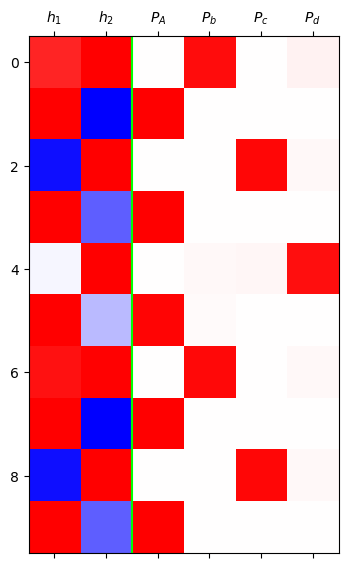

In [187]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

`-` yhat 값 분석

In [188]:
yhat.data.numpy().round(3)[:10]

-   미세하지만 뒤로갈수록 좀 더 성능이 좋다.

`-` h1,h2 분석 (= 임베딩스페이스 분석)

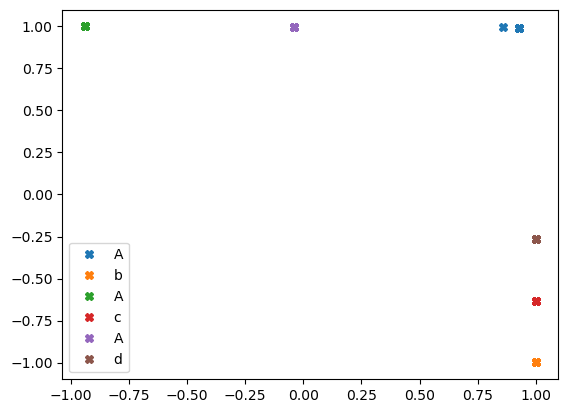

In [189]:
h1,h2 = h.T.data
plt.plot(h1[::6],h2[::6],'X',label="A")
plt.plot(h1[1::6],h2[1::6],'X',label="b")
plt.plot(h1[2::6],h2[2::6],'X',label="A")
plt.plot(h1[3::6],h2[3::6],'X',label="c")
plt.plot(h1[4::6],h2[4::6],'X',label="A")
plt.plot(h1[5::6],h2[5::6],'X',label="d")
plt.legend()

## D. 구현2 – RNNCell

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

`-` 데이터정리

In [190]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

`-` Net설계 및 가중치 설정 (구현1과 동일하도록 가중치 초기화)

In [191]:
torch.manual_seed(43052) 
_rnncell = rNNCell()
cook = torch.nn.Linear(2,4)

In [192]:
rnncell = torch.nn.RNNCell(4,2)
rnncell.weight_ih.data = _rnncell.i2h.weight.data 
rnncell.weight_hh.data = _rnncell.h2h.weight.data 
rnncell.bias_ih.data = _rnncell.i2h.bias.data 
rnncell.bias_hh.data = _rnncell.h2h.bias.data 

`-` 손실함수 및 옵티마이저 설정

In [193]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()),lr=0.1)

`-` 학습

In [194]:
L = len(X)
for epoc in range(200):
    ## 1~2 
    ht = torch.zeros(2) # 첫간장은 맹물
    loss = 0
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht) 
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과확인

In [195]:
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))
yhat

-   구현1과 같은 결과

# 5. HW: hello

아래와 같이 hello가 반복되는 자료가 있다고 하자.

In [176]:
txt = list('hello'*100)
txt[:10]

`(1)` `rNNCell`을 이용하여 학습하라. (적절한 은닉노드수를 설정할 것)

`(2)` `torch.nn.RNNCell`을 이용하여 (1)의 결과를 재현하라.